In [11]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [12]:
import sys
sys.path.append('/content/drive/MyDrive')

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from keras import backend as K

from dataset import DataGenerator
from SwinUNet import SwinUNet
from ConvUNet import ConvNeXTUNet

In [14]:
train_data = DataGenerator('/content/drive/MyDrive/data_/train', batch_size = 64)
val_data = DataGenerator('/content/drive/MyDrive/data_/val', batch_size = 64, predicting = True)

In [15]:
@tf.keras.saving.register_keras_serializable()
def dice_coef(y_true, y_pred):
  y_pred = tf.nn.softmax(y_pred)
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + 0.01) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.01)

@tf.keras.saving.register_keras_serializable()
def dice_coef_multilabel(y_true, y_pred, numLabels=35):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice

In [18]:
swin_model = SwinUNet(128, 35, window_size = 4, patch_size=4, embed_dim = 96, depths = [2, 2, 6, 2], num_heads = [3, 6, 12, 24], attn_drop_rate = 0.3, proj_drop_rate = 0.3)
swin_model.compile(
    optimizer=tf.keras.optimizers.AdamW(weight_decay = 0.0001, learning_rate = tf.keras.optimizers.schedules.CosineDecay(0.001, decay_steps = 15 * (len(train_data)))),
    loss = tf.keras.losses.CategoricalFocalCrossentropy(label_smoothing = 0.1, from_logits = True),
    metrics= ['accuracy', dice_coef_multilabel],
)

In [19]:
swin_history = swin_model.fit(train_data, epochs = 15, validation_data = val_data)

Epoch 1/15
47/47 [==============================] - 400s 7s/step - loss: 0.5999 - accuracy: 0.3558 - dice_coef_multilabel: 0.2280 - val_loss: 0.8971 - val_accuracy: 0.4829 - val_dice_coef_multilabel: 0.2714
Epoch 2/15
47/47 [==============================] - 156s 3s/step - loss: 0.3724 - accuracy: 0.6072 - dice_coef_multilabel: 0.2625 - val_loss: 0.3980 - val_accuracy: 0.5644 - val_dice_coef_multilabel: 0.2695
Epoch 3/15
47/47 [==============================] - 153s 3s/step - loss: 0.3405 - accuracy: 0.6525 - dice_coef_multilabel: 0.2912 - val_loss: 0.3684 - val_accuracy: 0.6191 - val_dice_coef_multilabel: 0.2808
Epoch 4/15
47/47 [==============================] - 160s 3s/step - loss: 0.3202 - accuracy: 0.6820 - dice_coef_multilabel: 0.3116 - val_loss: 0.3371 - val_accuracy: 0.6462 - val_dice_coef_multilabel: 0.3082
Epoch 5/15
47/47 [==============================] - 156s 3s/step - loss: 0.3084 - accuracy: 0.7008 - dice_coef_multilabel: 0.3310 - val_loss: 0.3204 - val_accuracy: 0.6629 

In [20]:
conv_model = ConvNeXTUNet(128, 96, 35, [3, 3, 9, 3])
conv_model.compile(
    optimizer=tf.keras.optimizers.AdamW(weight_decay = 0.0001, learning_rate = tf.keras.optimizers.schedules.CosineDecay(0.001, decay_steps = 15 * (len(train_data)))),
    loss = tf.keras.losses.CategoricalFocalCrossentropy(label_smoothing = 0.1, from_logits = True),
    metrics= ['accuracy', dice_coef_multilabel],
)

In [21]:
conv_history = conv_model.fit(train_data, epochs = 15, validation_data = val_data)

Epoch 1/15
47/47 [==============================] - 230s 4s/step - loss: 0.5202 - accuracy: 0.4559 - dice_coef_multilabel: 0.2679 - val_loss: 2.4789 - val_accuracy: 0.3362 - val_dice_coef_multilabel: 0.2899
Epoch 2/15
47/47 [==============================] - 175s 4s/step - loss: 0.3604 - accuracy: 0.6334 - dice_coef_multilabel: 0.2903 - val_loss: 0.5181 - val_accuracy: 0.5625 - val_dice_coef_multilabel: 0.2843
Epoch 3/15
47/47 [==============================] - 177s 4s/step - loss: 0.3317 - accuracy: 0.6747 - dice_coef_multilabel: 0.3038 - val_loss: 0.3734 - val_accuracy: 0.6363 - val_dice_coef_multilabel: 0.2833
Epoch 4/15
47/47 [==============================] - 174s 4s/step - loss: 0.3126 - accuracy: 0.7042 - dice_coef_multilabel: 0.3201 - val_loss: 0.3445 - val_accuracy: 0.6882 - val_dice_coef_multilabel: 0.3034
Epoch 5/15
47/47 [==============================] - 171s 4s/step - loss: 0.2993 - accuracy: 0.7205 - dice_coef_multilabel: 0.3352 - val_loss: 0.3326 - val_accuracy: 0.6879 

In [ ]:
os.makedirs('/content/drive/MyDrive/SaveModel/', exist_ok=True)
swin_model.save('/content/drive/MyDrive/SaveModel/swinmodel.keras', save_format="keras")

In [ ]:
os.makedirs('/content/drive/MyDrive/saveplots/swinmodel', exist_ok=True)

plt.figure(figsize=(12, 10))
plt.plot(swin_history.history['loss'], label='Train Loss')
plt.plot(swin_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/saveplots/swinmodel/lossplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12, 10))
plt.plot(swin_history.history['accuracy'], label='Train Accuracy')
plt.plot(swin_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/saveplots/swinmodel/accuracyplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12, 10))
plt.plot(swin_history.history['dice_coef_multilabel'], label='Train Dice Coefficient')
plt.plot(swin_history.history['val_dice_coef_multilabel'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.savefig('/content/drive/MyDrive/saveplots/swinmodel/diceplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [24]:
conv_model.save('/content/drive/MyDrive/SaveModel/convnextmodel.keras', save_format="keras")

In [ ]:
os.makedirs('/content/drive/MyDrive/saveplots/convmodel', exist_ok=True)

plt.figure(figsize=(12, 4))
plt.plot(conv_history.history['loss'], label='Train Loss')
plt.plot(conv_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/saveplots/convmodel/lossplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12, 4))
plt.plot(conv_history.history['accuracy'], label='Train Accuracy')
plt.plot(conv_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/saveplots/convmodel/accuracyplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12, 4))
plt.plot(conv_history.history['dice_coef_multilabel'], label='Train Dice Coefficient')
plt.plot(conv_history.history['val_dice_coef_multilabel'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.savefig('/content/drive/MyDrive/saveplots/convmodel/diceplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [26]:
for img, mask in val_data:
  true_mask = mask[:5]
  imgs = img[:5]
  break

prediction = swin_model.predict(tf.reshape(imgs, [5, 128, 128, 3]))
true_masks = np.argmax(true_mask, axis = -1)
predictions = np.argmax(prediction, axis = -1)

1/1 [==============================] - 5s 5s/step


In [ ]:
from labeldata import id_to_color
from PIL import Image

fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for index, (true_mask, prediction) in enumerate(zip(true_masks, predictions)):

    # Display the true mask
    temp = np.zeros([true_mask.shape[0], true_mask.shape[0], 3], dtype='uint8')
    for row in range(true_mask.shape[0]):
        for col in range(true_mask.shape[0]):
            temp[row, col, :] = id_to_color[true_mask[row, col]]

    axes[index, 0].imshow(temp)
    axes[index, 0].axis('off')
    # Display the corresponding prediction
    temp = np.zeros([prediction.shape[0], prediction.shape[0], 3], dtype='uint8')
    for row in range(prediction.shape[0]):
        for col in range(prediction.shape[0]):
            temp[row, col, :] = id_to_color[prediction[row, col]]

    axes[index, 1].imshow(temp)
    axes[index, 1].axis('off')

plt.tight_layout()
plt.show()



In [ ]:
for img, mask in val_data:
  true_mask = mask[:5]
  imgs = img[:5]
  break

prediction = conv_model.predict(tf.reshape(imgs, [5, 128, 128, 3]))
true_masks = np.argmax(true_mask, axis = -1)
predictions = np.argmax(prediction, axis = -1)

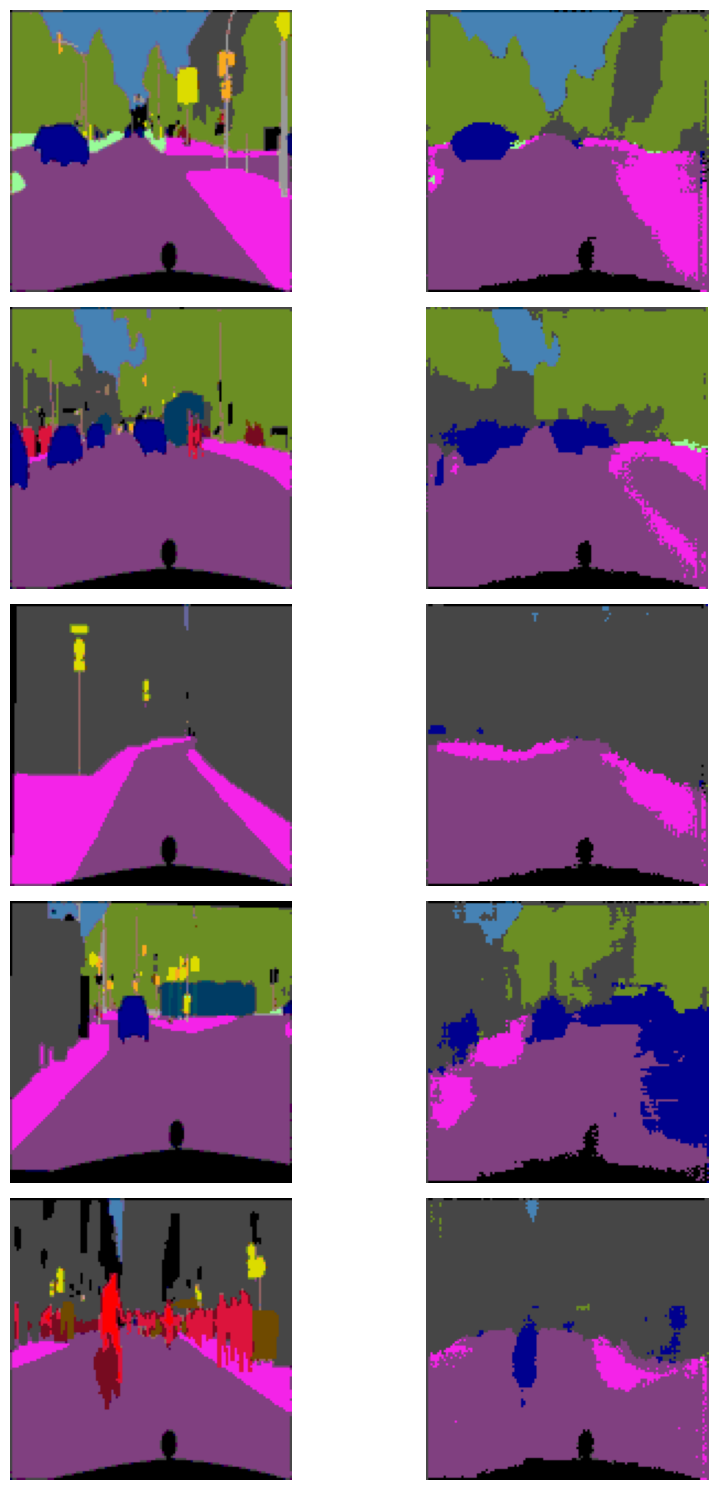

In [29]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for index, (true_mask, prediction) in enumerate(zip(true_masks, predictions)):

    # Display the true mask
    temp = np.zeros([true_mask.shape[0], true_mask.shape[0], 3], dtype='uint8')
    for row in range(true_mask.shape[0]):
        for col in range(true_mask.shape[0]):
            temp[row, col, :] = id_to_color[true_mask[row, col]]

    axes[index, 0].imshow(temp)
    axes[index, 0].axis('off')
    # Display the corresponding prediction
    temp = np.zeros([prediction.shape[0], prediction.shape[0], 3], dtype='uint8')
    for row in range(prediction.shape[0]):
        for col in range(prediction.shape[0]):
            temp[row, col, :] = id_to_color[prediction[row, col]]

    axes[index, 1].imshow(temp)
    axes[index, 1].axis('off')

plt.tight_layout()
plt.show()

